## Load the Data

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
df = pd.read_csv("data/model/Final_Data_Model.csv")

In [3]:
df.shape

(2225, 20)

In [4]:
# Socioeconomic and demographic predictors.
acs_predictors = [
    "PCT_BACHELORS_PLUS",
    "PCT_RENTERS",
    "PCT_LIMITED_ENGLISH",
    "MEDIAN_INCOME",
    "POVERTY_RATE",
    "PCT_NON_WHITE"
]

# Environmental predictors.
env_predictors = [
    "PCT_TREE_CANOPY",
    "PCT_IMPERVIOUS",
    "WCR",
    "NDVI"
]

# Urban form predictors.
# Parks were HIGHLY correlated to subway.
urban_predictors = [
    "BD",   # Building density.
    "AH",   # Weighted Average building height.
    "POI_500M_DENSITY", # Spatial feature
    "KNN_SUBWAY_dist_mean"
]

# Combined predictor set with all features.
all_predictors = env_predictors + acs_predictors + urban_predictors

# 2 targets
targets = ["heatweek_calls_per_1k", "normalweek_calls_per_1k"]

## Data Cleaning

### Population Distribution

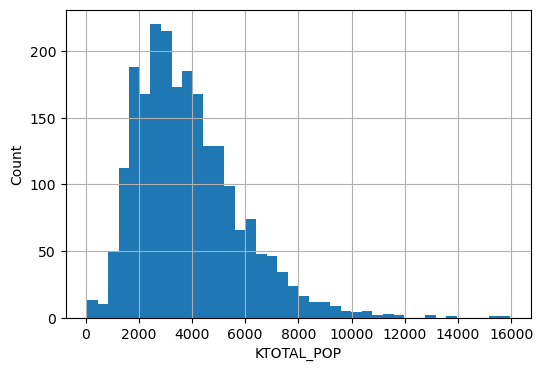

In [5]:
df["TOTAL_POP_x"].hist(bins=40, figsize=(6,4))
plt.xlabel("KTOTAL_POP")
plt.ylabel("Count")
plt.show()

### Targets Distribuiton

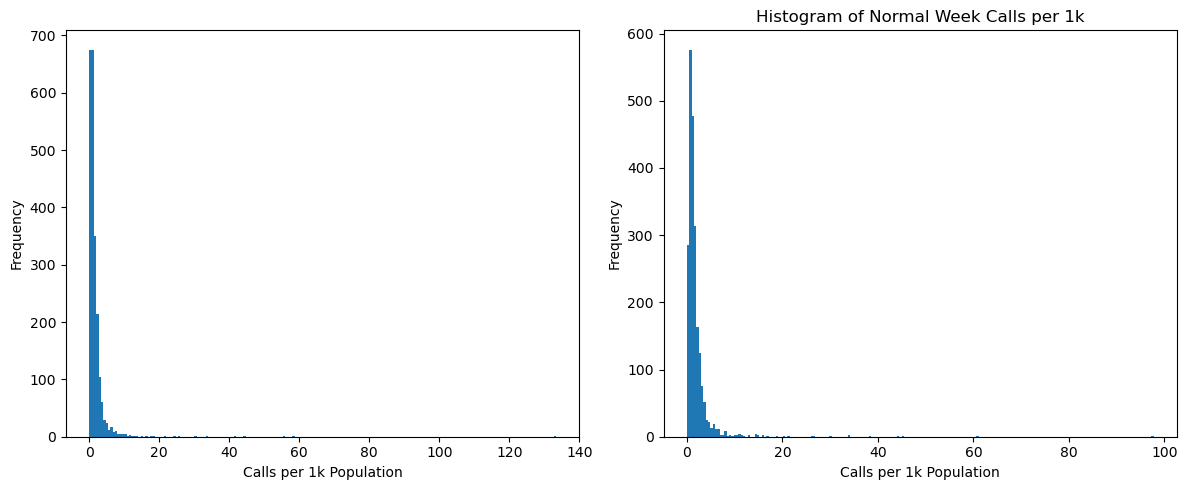

In [6]:
## Histogram
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for heatweek_calls_per_1k
plt.subplot(1, 2, 1)
plt.hist(df["heatweek_calls_per_1k"], bins=200)
plt.xlabel("Calls per 1k Population")
plt.ylabel("Frequency")

# Histogram for normalweek_calls_per_1k
plt.subplot(1, 2, 2)
plt.hist(df["normalweek_calls_per_1k"], bins=200)
plt.title("Histogram of Normal Week Calls per 1k")
plt.xlabel("Calls per 1k Population")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Log Transform

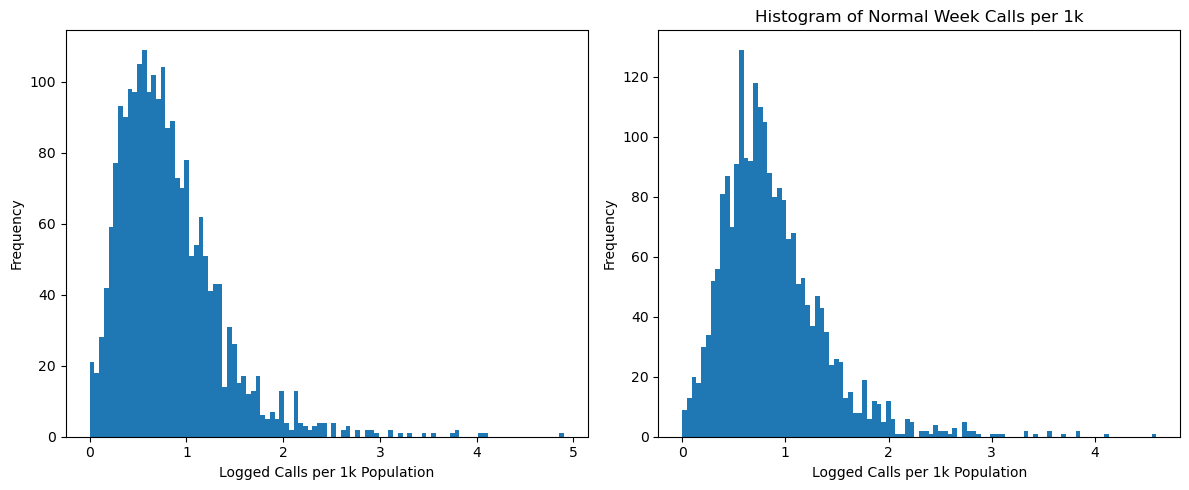

In [7]:
## Log Transformation for Targets

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for heatweek_calls_per_1k
plt.subplot(1, 2, 1)
plt.hist(np.log1p(df["heatweek_calls_per_1k"]), bins=100)
plt.xlabel("Logged Calls per 1k Population")
plt.ylabel("Frequency")

# Histogram for normalweek_calls_per_1k
plt.subplot(1, 2, 2)
plt.hist(np.log1p(df["normalweek_calls_per_1k"]), bins=100)
plt.title("Histogram of Normal Week Calls per 1k")
plt.xlabel("Logged Calls per 1k Population")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Clean the data with MEDIAN_INCOME < 0, and Total Tract Population < 500.

In [8]:
df = df[df["MEDIAN_INCOME"] > 0]
df = df[df["TOTAL_POP_x"] > 500]
df.shape

(2192, 20)

## OLS

In [9]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)



In [10]:
import statsmodels.api as sm


X = df[all_predictors]
X = (X - X.mean()) / X.std() ## Standardize features
# y = df["heatweek_calls_per_1k"]  
y = np.log1p(df["heatweek_calls_per_1k"])

X_const = sm.add_constant(X)
ols_sm = sm.OLS(y, X_const).fit()

print(ols_sm.summary())  


                              OLS Regression Results                             
Dep. Variable:     heatweek_calls_per_1k   R-squared:                       0.088
Model:                               OLS   Adj. R-squared:                  0.082
Method:                    Least Squares   F-statistic:                     14.94
Date:                   Wed, 03 Dec 2025   Prob (F-statistic):           4.79e-35
Time:                           22:02:54   Log-Likelihood:                -1453.7
No. Observations:                   2192   AIC:                             2937.
Df Residuals:                       2177   BIC:                             3023.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

In [11]:
X = df[all_predictors]
X = (X - X.mean()) / X.std() ## Standardize features
# y = df["normalweek_calls_per_1k"]  
y = np.log1p(df["normalweek_calls_per_1k"])

X_const = sm.add_constant(X)
ols_sm = sm.OLS(y, X_const).fit()

print(ols_sm.summary()) 

                               OLS Regression Results                              
Dep. Variable:     normalweek_calls_per_1k   R-squared:                       0.084
Model:                                 OLS   Adj. R-squared:                  0.078
Method:                      Least Squares   F-statistic:                     14.22
Date:                     Wed, 03 Dec 2025   Prob (F-statistic):           3.78e-33
Time:                             22:03:01   Log-Likelihood:                -1379.4
No. Observations:                     2192   AIC:                             2789.
Df Residuals:                         2177   BIC:                             2874.
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

## RF Model

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from tqdm.auto import tqdm

# ! pip install shap

#### Heatweek Model

In [13]:
# 1. Choose which target to model
target = "heatweek_calls_per_1k"  # 

# Log-transform the target to reduce skewness
df[target] = np.log1p(df[target])

X = df[all_predictors]
y = df[target]

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 3. Define RF pipeline (no scaler)
rf_pipeline = Pipeline([
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# 4. Hyperparameter grid (small, reasonable ranges)
param_grid = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["auto", "sqrt", 0.5],
}

# 5. GridSearchCV with 3-fold CV, optimizing RMSE
grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,
    # scoring="r2",  # use r2 to find the most fit model for explanation
    scoring="neg_root_mean_squared_error",  # sklearn uses negative for losses 
    n_jobs=-1,
    verbose=2
)

# 6. Fit on training data
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# 7. Evaluate on test data using best model
best_rf_pipeline = grid.best_estimator_

y_pred_test = best_rf_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\n=== Test set performance (Random Forest) ===")
print(f"R² (test):   {r2_test:.4f}")
print(f"RMSE (test): {rmse_test:.4f}")
print(f"MAE (test):  {mae_test:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\DZM\.conda\envs\geospatial\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
193 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DZM\.conda\envs\geospatial\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DZM\.conda\envs\geospatial\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\DZM\.conda\envs\geospatial\lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt

Best parameters: {'rf__max_depth': 30, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
Best CV RMSE: 0.4428078581968727

=== Test set performance (Random Forest) ===
R² (test):   0.2458
RMSE (test): 0.4149
MAE (test):  0.3129


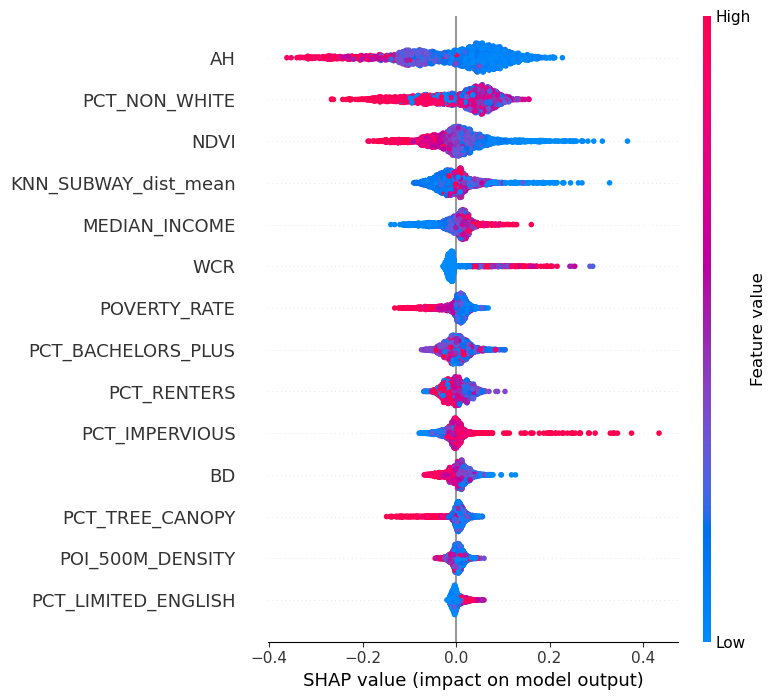

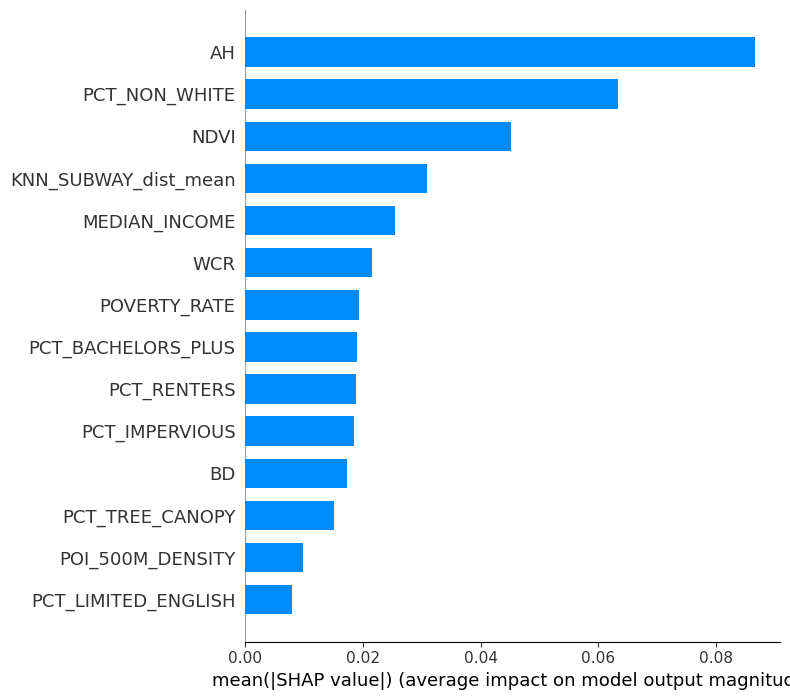

In [14]:
import shap
import matplotlib.pyplot as plt

# Initialize JS visualization (for notebooks)
shap.initjs()

# 1. Get the trained RandomForest model from the pipeline
rf_model = best_rf_pipeline.named_steps["rf"]

# 2. Convert full dataset into numpy array
X_full = X.values    # full data (train + test)

# 3. Build SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# 4. Compute SHAP values for test set
shap_values = explainer.shap_values(X_full)  # shape: (n_samples, n_features)

# 5. SHAP summary plot (beeswarm)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X,
    feature_names=all_predictors,
    show=True
)

# 6. SHAP bar plot (mean |SHAP| value)
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X,
    feature_names=all_predictors,
    plot_type="bar",
    show=True
)


#### Percentage Feature Importance

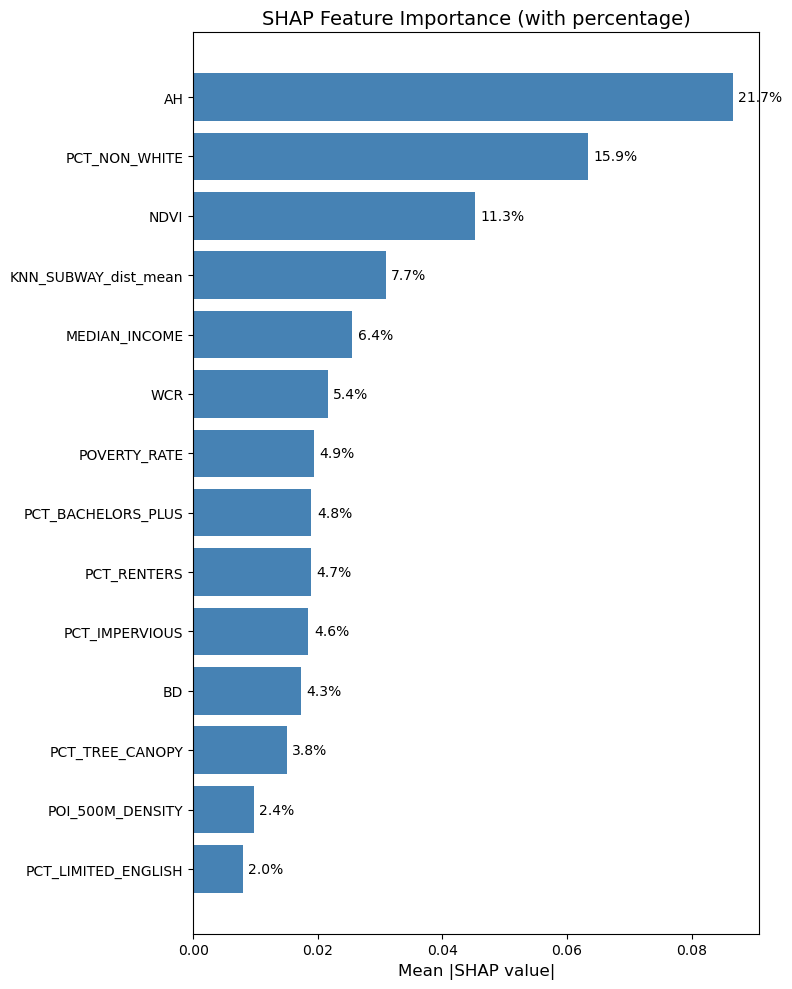

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# shap_values: shape = (n_samples, n_features)
# all_predictors: list of feature names

# 1. Compute mean absolute SHAP importance for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# 2. Put into DataFrame for easy plotting
shap_df = pd.DataFrame({
    "feature": all_predictors,
    "importance": mean_abs_shap
})

# 3. Sort by importance descending
shap_df = shap_df.sort_values("importance", ascending=False)

# 4. Compute percentage contribution
shap_df["percentage"] = shap_df["importance"] / shap_df["importance"].sum() * 100

# 5. Plot bar chart with percentage label
plt.figure(figsize=(8, 10))
bars = plt.barh(shap_df["feature"], shap_df["importance"], color="steelblue")

plt.xlabel("Mean |SHAP value|", fontsize=12)
plt.title("SHAP Feature Importance (with percentage)", fontsize=14)

# 6. Add percentage labels to each bar
for i, (value, pct) in enumerate(zip(shap_df["importance"], shap_df["percentage"])):
    plt.text(
        value + shap_df["importance"].max() * 0.01,  # small offset
        i,
        f"{pct:.1f}%",
        va="center",
        fontsize=10
    )

plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()

#### SHAP Plot for Feature of interest

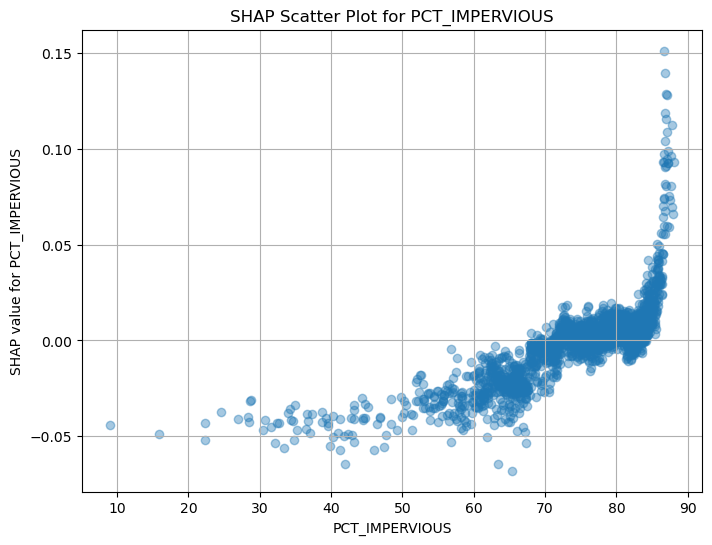

In [53]:
import matplotlib.pyplot as plt

feature = "PCT_IMPERVIOUS"     #
idx = all_predictors.index(feature)  

plt.figure(figsize=(8,6))
plt.scatter(
    X[feature],         
    shap_values[:, idx],     
    alpha=0.4
)

plt.xlabel(feature)
plt.ylabel(f"SHAP value for {feature}")
plt.title(f"SHAP Scatter Plot for {feature}")
plt.grid(True)
plt.show()

#### Print and Save SHAP Scatter Plots for all features

In [45]:
# Directory where the SHAP scatter plots will be saved
save_dir = "images/SHAP2/shap_scatter_plots_heat"
os.makedirs(save_dir, exist_ok=True)

# Loop through each predictor to generate SHAP scatter plots
for feature in all_predictors:

    # Get the column index of the current feature in the SHAP values array
    idx = all_predictors.index(feature)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X[feature],          # Raw feature values (global: train + test recommended)
        shap_values[:, idx], # Corresponding SHAP values
        alpha=0.45
    )

    # Axis labels and title
    plt.xlabel(feature, fontsize=12)
    plt.ylabel(f"SHAP value for {feature}", fontsize=12)
    plt.title(f"SHAP Scatter Plot for {feature}", fontsize=14)
    plt.grid(True)

    # Create a safe filename (avoid illegal characters)
    safe_name = feature.replace("/", "_").replace(" ", "_")
    filepath = os.path.join(save_dir, f"{safe_name}.png")

    # Save the figure
    plt.savefig(filepath, dpi=200, bbox_inches="tight")
    plt.close()

print("✓ All SHAP scatter plots have been saved to:", save_dir)

✓ All SHAP scatter plots have been saved to: images/SHAP2/shap_scatter_plots_heat


#### Regular heat week model

In [47]:
# 1. Choose which target to model
target2 = "normalweek_calls_per_1k"  

# Log-transform the target to reduce skewness
df[target2] = np.log1p(df[target2])

X = df[all_predictors]
y = df[target2]

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 3. Define RF pipeline (no scaler)
rf_pipeline = Pipeline([
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# 4. Hyperparameter grid 
param_grid = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["auto", "sqrt", 0.5],
}

# 5. GridSearchCV with 3-fold CV, optimizing RMSE
grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,
    ## scoring="r2", 
    scoring="neg_root_mean_squared_error",  # sklearn uses negative for losses 
    n_jobs=-1,
    verbose=2
)

# 6. Fit on training data
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# 7. Evaluate on test data using best model
best_rf_pipeline2 = grid.best_estimator_

y_pred_test = best_rf_pipeline2.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\n=== Test set performance (Random Forest) ===")
print(f"R² (test):   {r2_test:.4f}")
print(f"RMSE (test): {rmse_test:.4f}")
print(f"MAE (test):  {mae_test:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\DZM\.conda\envs\geospatial\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
141 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DZM\.conda\envs\geospatial\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DZM\.conda\envs\geospatial\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\DZM\.conda\envs\geospatial\lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt

Best parameters: {'rf__max_depth': 30, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 600}
Best CV RMSE: 0.21015411387026253

=== Test set performance (Random Forest) ===
R² (test):   0.2738
RMSE (test): 0.1940
MAE (test):  0.1537


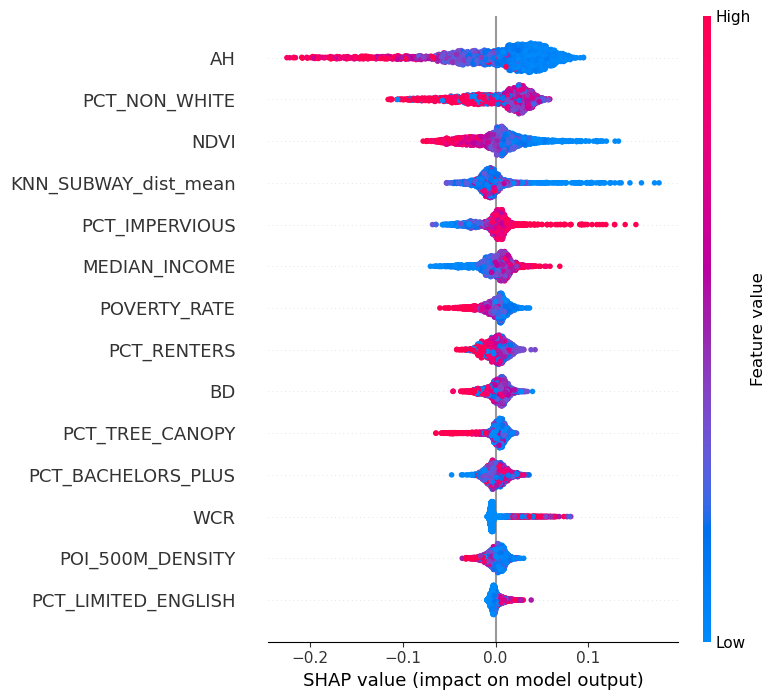

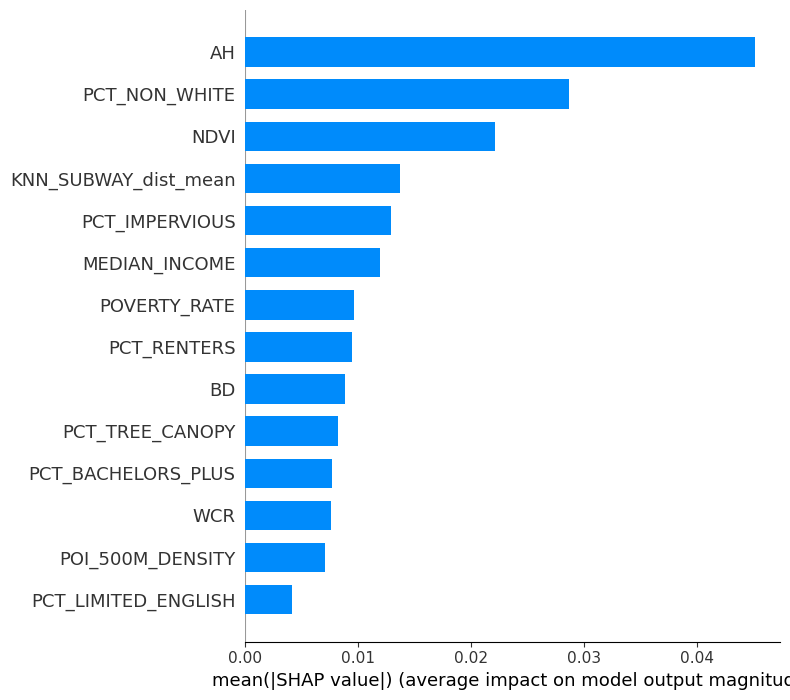

In [48]:
import shap
import matplotlib.pyplot as plt

# Initialize JS visualization (for notebooks)
shap.initjs()

# 1. Get the trained RandomForest model from the pipeline
rf_model2 = best_rf_pipeline2.named_steps["rf"]

# 2. Use training data as background for SHAP
X_full = X.values  # TreeExplainer can work with numpy arrays

# 3. Build SHAP explainer
explainer = shap.TreeExplainer(rf_model2)

# 4. Compute SHAP values for test set
shap_values = explainer.shap_values(X_full)  # shape: (n_samples, n_features)

# 5. SHAP summary plot (beeswarm)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X,
    feature_names=all_predictors,
    show=True
)

# 6. SHAP bar plot (mean |SHAP| value)
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X,
    feature_names=all_predictors,
    plot_type="bar",
    show=True
)


#### Percentage Feature Importance

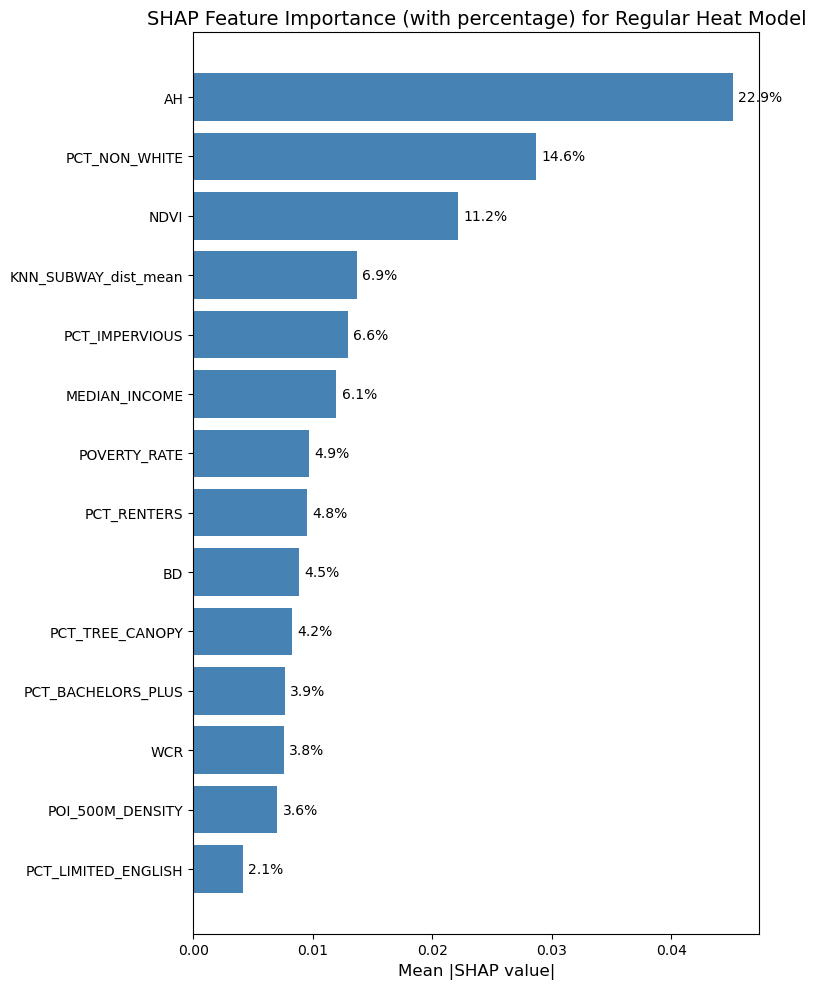

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# shap_values: shape = (n_samples, n_features)
# all_predictors: list of feature names

# 1. Compute mean absolute SHAP importance for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# 2. Put into DataFrame for easy plotting
shap_df = pd.DataFrame({
    "feature": all_predictors,
    "importance": mean_abs_shap
})

# 3. Sort by importance descending
shap_df = shap_df.sort_values("importance", ascending=False)

# 4. Compute percentage contribution
shap_df["percentage"] = shap_df["importance"] / shap_df["importance"].sum() * 100

# 5. Plot bar chart with percentage label
plt.figure(figsize=(8, 10))
bars = plt.barh(shap_df["feature"], shap_df["importance"], color="steelblue")

plt.xlabel("Mean |SHAP value|", fontsize=12)
plt.title("SHAP Feature Importance (with percentage) for Regular Heat Model", fontsize=14)

# 6. Add percentage labels to each bar
for i, (value, pct) in enumerate(zip(shap_df["importance"], shap_df["percentage"])):
    plt.text(
        value + shap_df["importance"].max() * 0.01,  # small offset
        i,
        f"{pct:.1f}%",
        va="center",
        fontsize=10
    )

plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


#### Print and Save SHAP Scatter Plots for all features

In [51]:
# Directory where the SHAP scatter plots will be saved
save_dir = "images/SHAP2/shap_scatter_plots_regular"
os.makedirs(save_dir, exist_ok=True)

# Loop through each predictor to generate SHAP scatter plots
for feature in all_predictors:

    # Get the column index of the current feature in the SHAP values array
    idx = all_predictors.index(feature)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X[feature],          # Raw feature values (global: train + test recommended)
        shap_values[:, idx], # Corresponding SHAP values
        alpha=0.45
    )

    # Axis labels and title
    plt.xlabel(feature, fontsize=12)
    plt.ylabel(f"SHAP value for {feature}", fontsize=12)
    plt.title(f"SHAP Scatter Plot for {feature}", fontsize=14)
    plt.grid(True)

    # Create a safe filename (avoid illegal characters)
    safe_name = feature.replace("/", "_").replace(" ", "_")
    filepath = os.path.join(save_dir, f"{safe_name}.png")

    # Save the figure
    plt.savefig(filepath, dpi=200, bbox_inches="tight")
    plt.close()

print("✓ All SHAP scatter plots have been saved to:", save_dir)

✓ All SHAP scatter plots have been saved to: images/SHAP2/shap_scatter_plots_regular


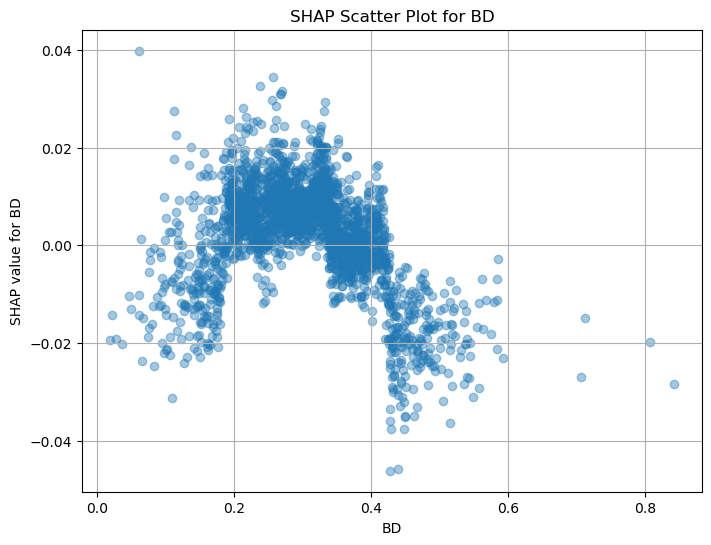

In [55]:
import matplotlib.pyplot as plt

feature = "BD"     #
idx = all_predictors.index(feature)  

plt.figure(figsize=(8,6))
plt.scatter(
    X[feature],         
    shap_values[:, idx],     
    alpha=0.4
)

plt.xlabel(feature)
plt.ylabel(f"SHAP value for {feature}")
plt.title(f"SHAP Scatter Plot for {feature}")
plt.grid(True)
plt.show()